<a href="https://colab.research.google.com/github/mmehmetaliyavuz/transformersteps/blob/main/transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

In [2]:
import torch
import torchvision
IMG_SIZE = 224
BATCH_SIZE = 32

In [3]:
!mkdir /content/data

In [4]:
import requests

url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
file_path = "/content/data/pizza_steak_sushi.zip"

with open(file_path, "wb") as f:
    request = requests.get(url)
    f.write(request.content)


In [5]:
import zipfile
with zipfile.ZipFile("/content/data/pizza_steak_sushi.zip", "r") as zip_ref:
  zip_ref.extractall("/content/data")

In [6]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                            torchvision.transforms.ToTensor()])

In [7]:
test_dir = "/content/data/test"
train_dir = "/content/data/train"
test_data = torchvision.datasets.ImageFolder(test_dir,transform)
train_data = torchvision.datasets.ImageFolder(train_dir,transform)

In [8]:
import os
NUM_WORKERS = os.cpu_count()
test_loader = torch.utils.data.DataLoader(test_data,BATCH_SIZE,False,num_workers=NUM_WORKERS)
train_loader = torch.utils.data.DataLoader(train_data,BATCH_SIZE,True,num_workers=NUM_WORKERS)
class_names = train_data.classes

In [9]:
class_names

['pizza', 'steak', 'sushi']

In [10]:
from google.colab.patches import cv2_imshow

In [11]:
image, label = next(iter(train_loader))[0][0], next(iter(train_loader))[1][0]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [12]:
image.shape

torch.Size([3, 224, 224])

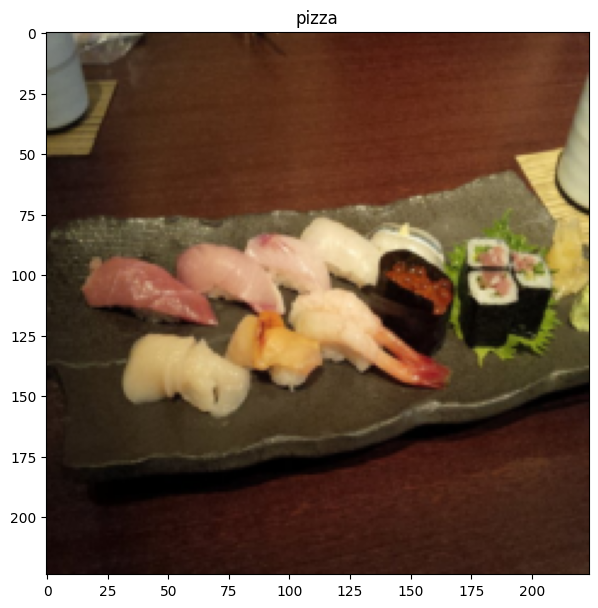

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,10))
plt.title(class_names[label])
plt.imshow(image.permute(1,2,0))
img = image.numpy().copy()

In [14]:
h = 224
w = 224
cc = 3
psize = 16
N = int(h*w)/(16*16)
N

196.0

In [15]:
patch = 16
#image = image.permute(1,2,0)
height, width, channels = image.shape
piece_height = height // patch
piece_width = width // patch
pieces = []
for i in range(piece_height):
  for j in range(piece_height):
    piece = piece = image[i*piece_height:(i+1)*piece_height, j*piece_width:(j+1)*piece_width]

    pieces.append(piece)

<Figure size 1000x1000 with 0 Axes>

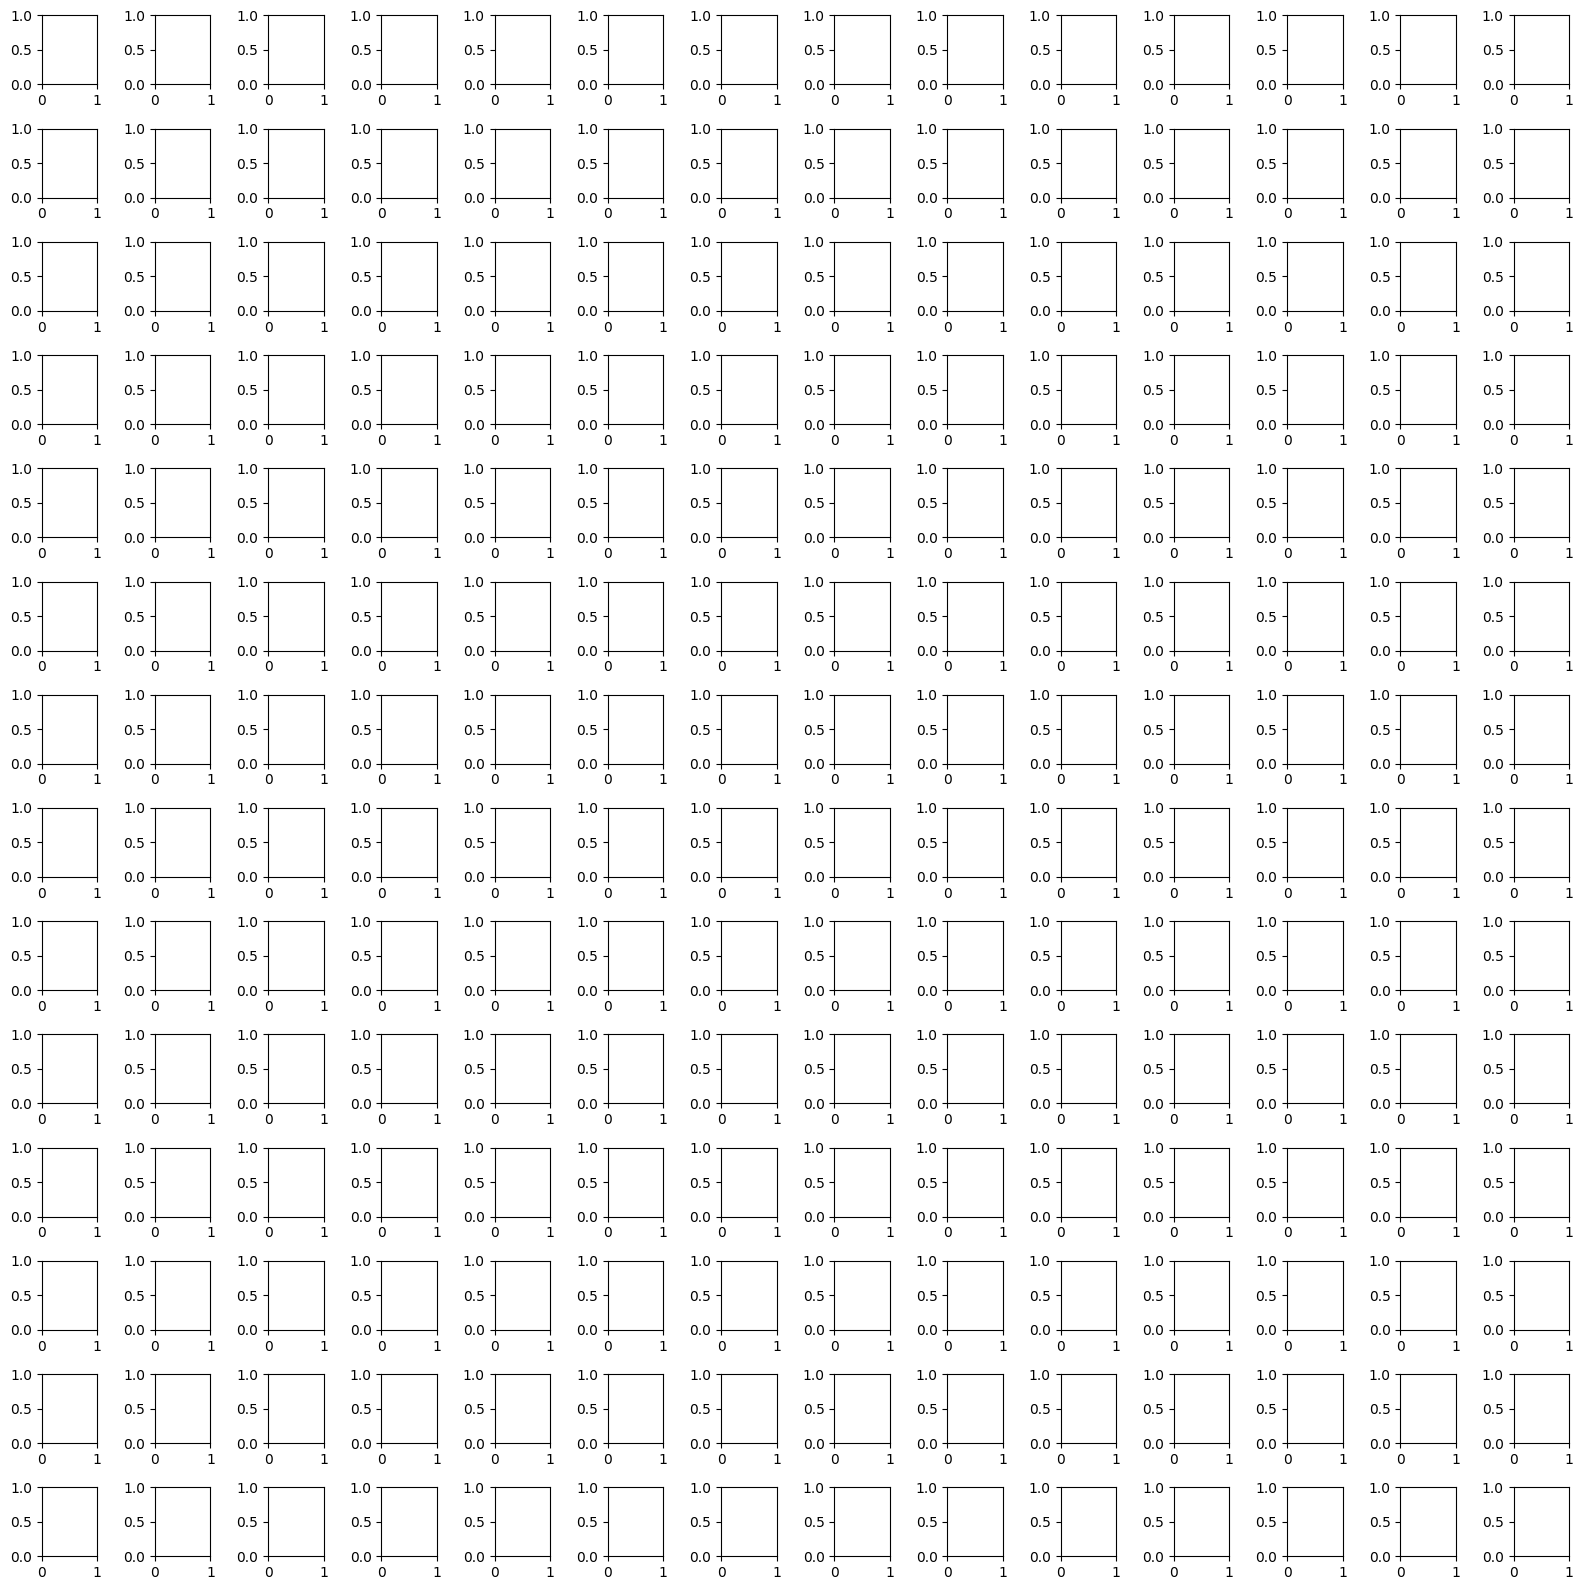

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
# Yerleşim düzeni ayarla
num_rows = 14
num_cols = 14
fig, axes = plt.subplots(num_rows, num_cols,figsize=(16,16))

# Parçaları göster
for idx, piece in enumerate(pieces):
    row = idx // num_cols
    col = idx % num_cols
    axes[row, col].imshow(piece)
    axes[row, col].label_outer()

plt.subplots_adjust(wspace=0.000001)
plt.tight_layout()
plt.show()


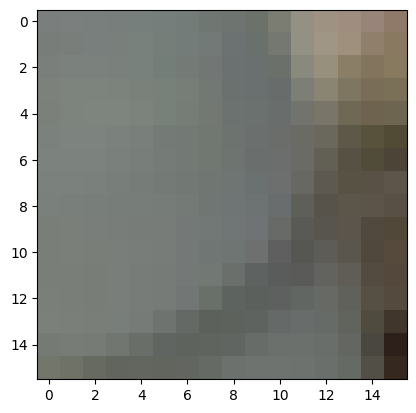

In [17]:
plt.imshow(image.permute(1,2,0)[0:16,0:16])

In [18]:
224/32

7.0

In [19]:
from torch import nn

patch_size = 16
con2d = nn.Conv2d(in_channels=3,
                  out_channels=768,
                  kernel_size=patch_size,
                  stride=patch_size,
                  padding=0)
con2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [20]:
imageOoConv2d = con2d(image.unsqueeze(0))
imageOoConv2d.shape

torch.Size([1, 768, 14, 14])

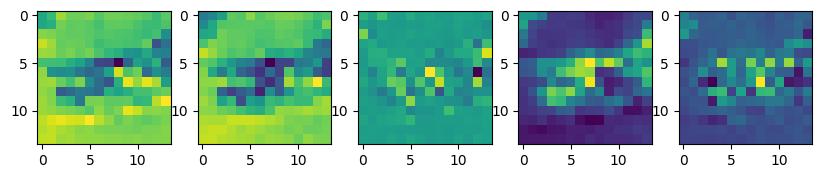

In [21]:
fig, ax = plt.subplots(1,5,figsize=(10,10))
for i in range(5):
  im = imageOoConv2d[:,i,:,:]
  ax[i].imshow(im.squeeze().detach().numpy())

In [22]:
flatten_layer = nn.Flatten(2,3)

In [23]:
flatten_layer(imageOoConv2d[:,:,:,:]).shape

torch.Size([1, 768, 196])

In [24]:
flatten_layer(imageOoConv2d[:,:,:,:]).permute(0,2,1).shape

torch.Size([1, 196, 768])

In [25]:
def returner(image):
  return flatten_layer(con2d(image.unsqueeze(0))).permute(0,2,1)

In [26]:
plt.figure(figsize=(15,15))
plt.imshow(returner(image)[:,:,1].detach().numpy())
plt.axis(False)

(-0.5, 195.5, 0.5, -0.5)

In [27]:
class Datater(nn.Module):
  def __init__(self, in_channels,embedding_dim,patch_size) -> None:
     super().__init__()
     self.conv2d = nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0)
     self.flatten = nn.Flatten(2,3)
  def forward(self,image):
    image = image.unsqueeze(0)
    conved = self.conv2d(image)
    flattened = self.flatten(conved)
    return flattened.permute(0,2,1)


In [28]:
datater = Datater(3,768,16)

In [29]:
embedded_patched = datater(image)

In [30]:
class_token = nn.Parameter(torch.ones(embedded_patched.shape[0],1,embedded_patched.shape[-1]),requires_grad=True)
class_token

Parameter containing:
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 

In [31]:
classed_embedded_patched = torch.cat((class_token,embedded_patched),dim=1)
classed_embedded_patched

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.0723,  0.4230,  0.2825,  ..., -0.1893, -0.3419,  0.1530],
         [ 0.0593,  0.3022,  0.1061,  ..., -0.0998, -0.3567,  0.1120],
         ...,
         [ 0.0413,  0.1947,  0.0691,  ..., -0.0447, -0.1951,  0.0246],
         [ 0.0241,  0.2035,  0.0829,  ..., -0.0587, -0.1932,  0.0437],
         [ 0.0561,  0.1997,  0.0876,  ..., -0.0759, -0.1981,  0.0538]]],
       grad_fn=<CatBackward0>)

In [32]:
classed_embedded_patched.shape

torch.Size([1, 197, 768])

In [33]:
posi_emmed = nn.Parameter(torch.ones(1,classed_embedded_patched.shape[1],classed_embedded_patched.shape[2]),requires_grad=True)
posi_emmed.shape

torch.Size([1, 197, 768])

In [34]:
last = classed_embedded_patched + posi_emmed

In [35]:
last.shape

torch.Size([1, 197, 768])

In [36]:
class Datater(nn.Module):
  def __init__(self, in_channels,embedding_dim,patch_size) -> None:
     super().__init__()
     self.conv2d = nn.Conv2d(in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0)
     self.flatten = nn.Flatten(2,3)
  def forward(self,image):
    image = image.unsqueeze(0)
    conved = self.conv2d(image)
    flattened = self.flatten(conved)
    return flattened.permute(0,2,1)

In [37]:
224/14

16.0

In [38]:
patch_size = 16
h,w = image.shape[1],image.shape[2]
datader = Datater(3,embedding_dim=(patch_size**2*3),patch_size=patch_size)
patched = datater(image)
batch_size = patched.shape[0]
embedding_dim = patched.shape[-1]
class_token = nn.Parameter(torch.ones((batch_size, 1, embedding_dim)), requires_grad=True)
classed_embedded_patched = torch.cat((class_token,patched),dim=1)
posi_emmed = nn.Parameter(torch.ones(1,classed_embedded_patched.shape[1],classed_embedded_patched.shape[2]),requires_grad=True)
finalized_tensor = classed_embedded_patched + posi_emmed

In [39]:
finalized_tensor

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.0723, 1.4230, 1.2825,  ..., 0.8107, 0.6581, 1.1530],
         [1.0593, 1.3022, 1.1061,  ..., 0.9002, 0.6433, 1.1120],
         ...,
         [1.0413, 1.1947, 1.0691,  ..., 0.9553, 0.8049, 1.0246],
         [1.0241, 1.2035, 1.0829,  ..., 0.9413, 0.8068, 1.0437],
         [1.0561, 1.1997, 1.0876,  ..., 0.9241, 0.8019, 1.0538]]],
       grad_fn=<AddBackward0>)

In [40]:
finalized_tensor.shape

torch.Size([1, 197, 768])

In [41]:
class MultiheadAttentionLayer(nn.Module):
  def __init__(self,embedding_dim,num_heads=12,dropout=0) -> None:
    super().__init__()
    self.multiHead = torch.nn.MultiheadAttention(embedding_dim,
                                                 num_heads,
                                                 dropout,
                                                 bias=True,
                                                 add_bias_kv=False,
                                                 add_zero_attn=False,
                                                 kdim=None,
                                                 vdim=None,
                                                 batch_first=True,
                                                 device=None,
                                                 dtype=None)
    self.layerNorm = torch.nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-05, elementwise_affine=True, bias=True, device=None, dtype=None)

  def forward(self,x):
    x = self.layerNorm(x)
    x, _ = self.multiHead(x,x,x,need_weights=False)
    return x

In [42]:
attenter = MultiheadAttentionLayer(embedding_dim,12,0.0)

In [43]:
attented = attenter(finalized_tensor)

In [44]:
import torchvision

In [45]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dim=768,mlp_size=3072,dropout=0.1) -> None:
    super().__init__()
    self.layerNorm = torch.nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-05, elementwise_affine=True, bias=True, device=None, dtype=None)
    self.MLP = nn.Sequential(
        nn.Linear(in_features=embedding_dim,out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,out_features=embedding_dim),
        nn.Dropout(p=dropout),
    )
  def forward(self,x):
    x = self.layerNorm(x)
    x = self.MLP(x)
    return x


In [46]:
blocker = MLPBlock()

In [47]:
blocked = blocker(attented)
blocked

tensor([[[ 0.2647, -0.2281,  0.4484,  ..., -0.0177,  0.0000, -0.1000],
         [ 0.3813, -0.1059,  0.0000,  ..., -0.0530, -0.0625, -0.0954],
         [ 0.2918, -0.0642,  0.4810,  ...,  0.0066,  0.1030, -0.0000],
         ...,
         [ 0.4942, -0.1502,  0.4552,  ..., -0.0000, -0.0791, -0.1445],
         [ 0.2986, -0.0636,  0.3420,  ...,  0.0681, -0.0076, -0.0558],
         [ 0.0000, -0.1032,  0.4922,  ..., -0.0678, -0.0118, -0.0398]]],
       grad_fn=<MulBackward0>)

In [48]:
attented

tensor([[[-0.4235, -0.3531,  0.4450,  ...,  0.5559, -0.7179, -0.4014],
         [-0.4196, -0.3505,  0.4363,  ...,  0.5716, -0.7319, -0.3954],
         [-0.4231, -0.3531,  0.4417,  ...,  0.5728, -0.7266, -0.3983],
         ...,
         [-0.4208, -0.3505,  0.4383,  ...,  0.5689, -0.7297, -0.4009],
         [-0.4199, -0.3518,  0.4384,  ...,  0.5695, -0.7297, -0.4000],
         [-0.4195, -0.3510,  0.4385,  ...,  0.5692, -0.7301, -0.3995]]],
       grad_fn=<TransposeBackward0>)

In [53]:
class TransformerEncoder(nn.Module):
  def __init__(self, embedding_dim=768, num_heads=12, mlp_size=3072, mlp_dropout=0.1, attdropout=0) -> None:
    super().__init__()
    self.MHSE = MultiheadAttentionLayer(embedding_dim,num_heads,attdropout)
    self.MLP = MLPBlock(embedding_dim,mlp_size,mlp_dropout)
    #self.layerNorm = torch.nn.LayerNorm(normalized_shape=embedding_dim, eps=1e-05, elementwise_affine=True, bias=True, device=None, dtype=None)

  def forward(self,x):
    x = self.MHSE(x)+ x
    x = self.MLP(x) + x
    return x


In [54]:
encoder = TransformerEncoder()

In [57]:
encoded = encoder(attented)
encoded

tensor([[[-1.1296, -0.3269,  0.6501,  ...,  0.6379, -1.1240, -0.3720],
         [-1.2695, -0.4733,  0.6321,  ...,  0.7796, -1.4040, -0.3442],
         [-1.2112, -0.1938,  0.6538,  ...,  0.6758, -1.2636, -0.3240],
         ...,
         [-1.1525, -0.5864,  0.7209,  ...,  0.7901, -0.8977, -0.3707],
         [-1.2218, -0.5014,  0.6341,  ...,  0.6515, -1.3972, -0.3389],
         [-1.2324, -0.3851,  0.6445,  ...,  0.7971, -1.2456, -0.3433]]],
       grad_fn=<AddBackward0>)

In [65]:
#!pip install torchinfo
from torchinfo import summary
summary(encoder,
        input_size=(1,197,768),
        col_names=["input_size","output_size","num_params","trainable"]
        )

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
TransformerEncoder                       [1, 197, 768]             [1, 197, 768]             --                        True
├─MultiheadAttentionLayer: 1-1           [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm: 2-1                    [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─MultiheadAttention: 2-2           [1, 197, 768]             [1, 197, 768]             2,362,368                 True
├─MLPBlock: 1-2                          [1, 197, 768]             [1, 197, 768]             --                        True
│    └─LayerNorm: 2-3                    [1, 197, 768]             [1, 197, 768]             1,536                     True
│    └─Sequential: 2-4                   [1, 197, 768]             [1, 197, 768]             --                        True
│  




```
self attention == MHSA(multi head self attention layer)
feed forward == classic neural network or MLP

```



In [67]:
torch_transformerencoderlayer = torch.nn.TransformerEncoderLayer(embedding_dim,12,3072,0.1,"gelu",batch_first=True,norm_first=True)